# What can be learned?

The metaphysical question of what can be learned is not typically considered in our daily lives, as we often focus on the more practical question of how something can be learned.
However, when transferring human learning achievements, understanding, and comprehension to a machine, we must consider not only how a machine could learn this information but also whether it is possible for the machine to learn it at all.

As cultural beings, our perception of any circumstance is inevitably influenced by its implicit cultural framework.
Frameworks such as critical theory aim to uncover how these implicit structures shape our understanding. For example, when discussing transportation, we already have subjective associations and relations with the topic.

This concept also applies to music, as illustrated by the different perceptions of tuning systems in different cultures.
To approximate such sensory sensitivity in a machine learning model, we need to use mathematical formalism.
The basic idea of machine learning is that this sensitivity and information is embedded in data, and its underlying and inherent patterns can be detected and extracted.

A machine learning algorithm is essentially a mathematical function with numerous variables that maps an input to an output, a result.
One might assume that it is always necessary to provide pairs of inputs and outputs to identify a structure.
However, it is often sufficient to present enough data for the algorithm to discern patterns.

This can be demonstrated by comparing images of hand-drawn digits, such as the numbers 3 and 8, from the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database).

```{figure} assets/mnist_3.png

Some examples of a handwritten $3$ of the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database).
```

```{figure} assets/mnist_8.png

Some examples of a handwritten $8$ of the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database).
```

Within this document, we want to take a look how to analyze data and question how different mathematical functions implement capabilities to *learn* tasks of different *complexity*.


## Analyzing data

We want to take a first look on how to analyze data from within Python by making use of tools such as *numpy* (for mathematical operations), *pandas* (for data aggregation and managing) and *matplotlib* (for plotting data).
The dataset we will take a small look at will be the already mentioned MNIST dataset.

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import MNIST

%config InlineBackend.figure_format = 'svg'

# load the MNIST dataset
mnist = MNIST(root=Path.cwd().joinpath("..", "data", "mnist"), download=True)

# convert data to a numpy array
mnist_data = mnist.data.numpy()

# get the indices of the dataset series which are showing 3 / 8
idx_3 = np.where(mnist.targets == 3)
idx_8 = np.where(mnist.targets == 8)

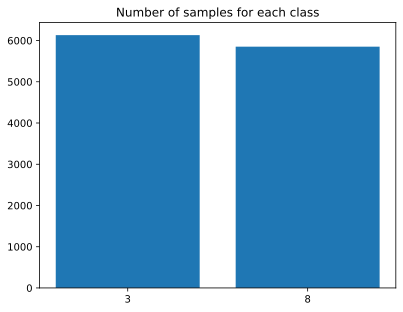

In [ ]:
plt.title("Number of samples for each class")
plt.bar(["3", "8"], [len(idx_3[0]), len(idx_8[0])]);

Already with this, we can take a look the different kind of variety these two numbers have.

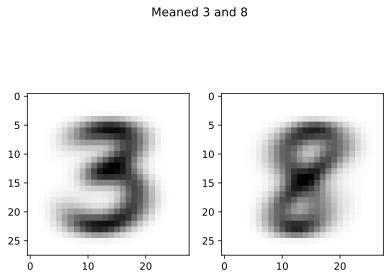

In [ ]:
fig, (ax_1, ax_2) = plt.subplots(1, 2)
plt.suptitle("Meaned 3 and 8")

ax_1.imshow(mnist_data[idx_3].mean(axis=0), cmap="gray_r")
ax_2.imshow(mnist_data[idx_8].mean(axis=0), cmap="gray_r");

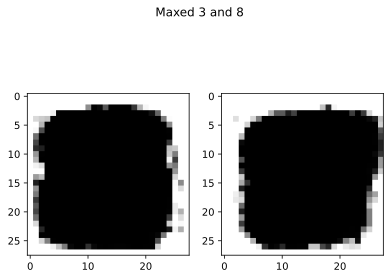

In [ ]:
fig, (ax_1, ax_2) = plt.subplots(1, 2)
plt.suptitle("Maxed 3 and 8")

ax_1.imshow(mnist_data[idx_3].max(axis=0), cmap="gray_r")
ax_2.imshow(mnist_data[idx_8].max(axis=0), cmap="gray_r");

We can also take a look at the variance which measures the average amount of deviation from the mean value.
For a discrete *random variable* $X$ this is defined via

$$
\text{Var}(X) = \frac{1}{n} \sum_{i=1}^{n} \left( x_i - \mu \right)^2 
$$

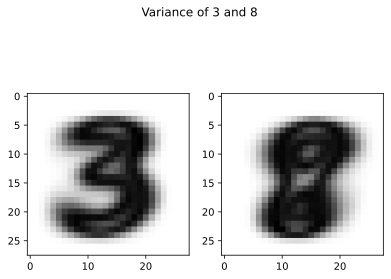

In [ ]:
fig, (ax_1, ax_2) = plt.subplots(1, 2)
plt.suptitle("Variance of 3 and 8")

ax_1.imshow(mnist_data[idx_3].var(axis=0), cmap="gray_r")
ax_2.imshow(mnist_data[idx_8].var(axis=0), cmap="gray_r");

It is interesting to see that the variance at the center of $8$ is quite low, which tells us that nearly all samples of our 8 go through the center.

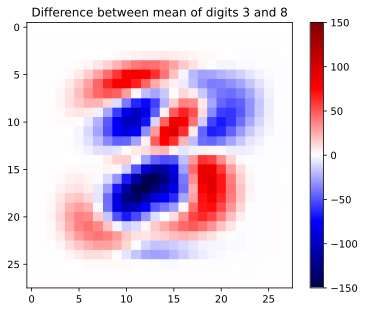

In [ ]:
import matplotlib as mpl

plt.title("Difference between mean of digits 3 and 8")

mean_3 = mnist_data[idx_3].mean(axis=0)
mean_8 = mnist_data[idx_8].mean(axis=0)

plt.imshow(
    mean_3 - mean_8, cmap="seismic", norm=mpl.colors.Normalize(vmin=-150, vmax=150)
)
plt.colorbar();

## What to derive from data analysis

This analysis can already help us to formulate a first, very naive model to guess if the shown sample is either a $3$ or an $8$, based on a single pixel.
We start again by calculating the mean image for each class.

In [ ]:
mean_3 = mnist_data[idx_3].mean(axis=0).flatten()
mean_8 = mnist_data[idx_8].mean(axis=0).flatten()

Now we will use this mean values to find the actual pixel which has the biggest absolute difference between both classes.

In [ ]:
pixel_differences = np.abs(mean_3 - mean_8)
idx_highest_pixel_diff = np.argmax(pixel_differences)

print(
    f"Pixel with highest difference is #{idx_highest_pixel_diff} with value {pixel_differences[idx_highest_pixel_diff]}"
)

Pixel with highest difference is #488 with value 151.27191629148817


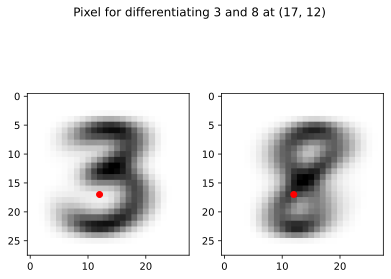

In [ ]:
image_shape = (28, 28)

best_pixel_coords = np.unravel_index(idx_highest_pixel_diff, image_shape)

fig, (ax_1, ax_2) = plt.subplots(1, 2)
plt.suptitle("Variance of 3 and 8")

ax_1.imshow(mean_3.reshape(image_shape), cmap="gray_r")
ax_1.scatter([best_pixel_coords[1]], [best_pixel_coords[0]], color="red")

ax_2.imshow(mean_8.reshape(image_shape), cmap="gray_r")
ax_2.scatter([best_pixel_coords[1]], [best_pixel_coords[0]], color="red")

plt.suptitle(f"Pixel for differentiating 3 and 8 at {best_pixel_coords}")
plt.show();

By taking a look if this given pixel is closer to the corresponding value of the mean of $3$ and $8$, we will decide accordingly.
We can do this by calculating the mean between both values.

In [ ]:
threshold = (mean_3[idx_highest_pixel_diff] + mean_8[idx_highest_pixel_diff]) / 2


def is_it_3_or_8(sample, pixel_index, threshold):
    return 3 if sample[pixel_index] < threshold else 8

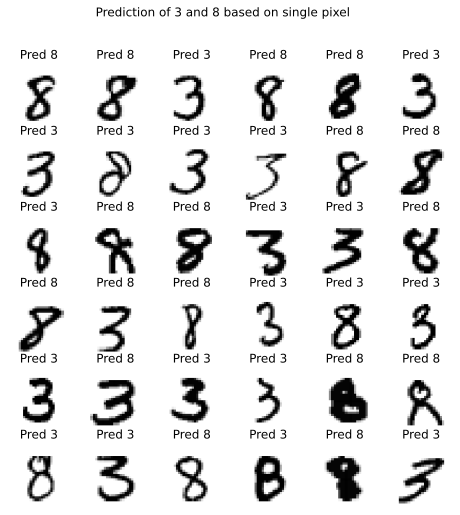

In [ ]:
fig, axs = plt.subplots(6, 6, figsize=(8, 8))

plt.suptitle("Prediction of 3 and 8 based on single pixel")

for ax in axs.flatten():
    rand_index = np.random.choice(
        np.concatenate([idx_3[0].flatten(), idx_8[0].flatten()])
    )
    rand_im = mnist_data[rand_index]
    predicted_number = is_it_3_or_8(
        sample=rand_im.flatten(),
        pixel_index=idx_highest_pixel_diff,
        threshold=threshold,
    )
    ax.imshow(rand_im, cmap="gray_r")
    ax.axis("off")
    ax.title.set_text(f"Pred {predicted_number}")

plt.show();

In [ ]:
X = np.concatenate(
    [
        mnist_data[idx_3].reshape(-1, 28 * 28),
        mnist_data[idx_8].reshape(-1, 28 * 28),
    ]
)
y = np.concatenate(
    [
        np.zeros(shape=(idx_3[0].shape)),
        np.ones(shape=(idx_8[0].shape)),
    ]
)
y_pred = X[:, idx_highest_pixel_diff] > threshold

# Calculate accuracy
accuracy = np.mean(y_pred == y)
print(f"Model accuracy: {accuracy:.2f}")

Model accuracy: 0.83


An accuracy of around $86\%$ is not great, but also not terrible, considering we're only using a single pixel.
We've identified the two key parameters: the pixel and its threshold value, which help distinguish the classes.
However, remember that random guessing would give us $50\%$ accuracy.

```{admonition} Task
* Do this for another pair of numbers
* How can we find the 2nd most significant pixel if we settled already for the first pixel?
```

## McCulloch and Pitts model

In 1943 Warren McCulloch and Walter Pitts proposed a model of an artificial neuron {cite}`McCulloch1943`, called the McCulloch Pitts cell and acts very similar to our efforts by separating the values of $3$ and $8$ based on a single pixel.
It is one of the earliest models of a neuron in the field of machine learning, as it was designed to mimic the behavior of biological neurons in a simplified manner.

Mathematically, an $n$-dimensional neuron can be described via the summation of an $n$ dimensional binary input vector $x$, which gets compared to a threshold $\Theta$, which can be written as

$$
y = f(x) = \begin{cases}
    1 & \text{ if } ~ \sum_{i=1}^{n} x_i  \geq \Theta \\
    0 & \text{else}
\end{cases}
$$


```{figure} https://upload.wikimedia.org/wikipedia/commons/a/a7/Diagram_of_a_McCulloch-Pitts-cell.svg

A graphical representation of a McCulloch-Pitts cell with $n$ inputs and $\Theta$ as activation threshold. Source <https://commons.wikimedia.org/wiki/File:Diagram_of_a_McCulloch-Pitts-cell.svg>.
```


```{admonition} Task
* Can you implement the following functions with said model?

    * and
    * or
    * not
    * [xor](https://en.wikipedia.org/wiki/Exclusive_or)

  If, what are the thresholds of the neuron?
* Read https://towardsdatascience.com/mcculloch-pitts-model-5fdf65ac5dd1
```

## Perceptron

In 1957, Frank Rosenblatt suggested an extension to the McCulloch pitts model called a [*Perceptron*](https://en.wikipedia.org/wiki/Perceptron).
The model changes the $n$-dimensional binary input vector $x$ to a real-valued input vector,
Additionally, each of the values $x_i$ of this vector $x$ as a *weight* $w_i$ associated, which are collected in the vector $w$.
These *weights* act as a scaling for our input data and can be adjusted.

The perceptron can therefore be described via

$$
y = f(x) = \begin{cases}
    1 & \text{ if } ~ \sum_{i=1}^{n} w_i x_i  \geq \Theta \\
    0 & \text{else}
\end{cases}
$$

Instead of adjusting the weights manually we can describe an algorithm to approximate those weights.

We start by transforming the pixels of each square $28 \times 28$ image into a $784$ dimensional vector.
Additionally, we will create a vector $y$ which maps $3$ to $0$ and $8$ to $1$ for each value.

In [ ]:
# prepare dataset
X = np.concatenate(
    [mnist_data[idx_3].reshape(-1, 28 * 28), mnist_data[idx_8].reshape(-1, 28 * 28)]
)
y = np.concatenate(
    [
        np.zeros(shape=(idx_3[0].shape)),
        np.ones(shape=(idx_8[0].shape)),
    ]
)

print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (11982, 784)
y: (11982,)


As we transferred the images and the number it is representing into a vector, we can now take a look how to find some good weights, such that we can calculate what we did prior manually on a single pixel now for the whole image.

Model accuracy: 0.97


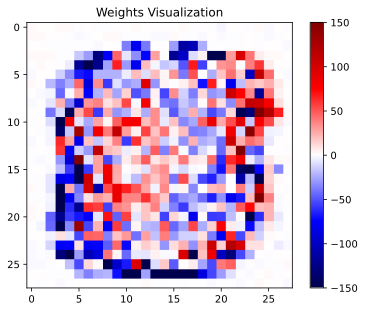

In [ ]:
# makes the outcome deterministic
np.random.seed(0)

# create a random weight for each input vector
weights = np.random.randn(X.shape[-1])

# create a random threshold value to begin with - this is often also called a bias
theta = np.random.randn()

# python implementation of the formula above


def mc_culloch_pitts_neuron(X, weights, theta):
    y = np.dot(X, weights)
    return 1 if y >= theta else 0


# learning parameters
learning_rate = 0.01
# number of iterations through our dataset
num_epochs = 100

# the actual training loop
for epoch in range(num_epochs):
    # we shuffle our dataset so we don't start by seeing all examples of a
    # 3 first and afterwards all 8s
    random_indices = np.arange(X.shape[0])
    np.random.shuffle(random_indices)

    # now iterate over our dataset
    for i in random_indices:
        # calculate the current outcome
        prediction = mc_culloch_pitts_neuron(X[i], weights, theta)

        # calculate our error which is the difference between our outcome
        # and the actual value
        error = y[i] - prediction

        # we will try to adjust the weights by adjusting the weights
        # into the "proper" direction. We limit how much we can move into
        # this direction by the learning_rate
        weights += learning_rate * error * X[i]

        # we do the same for our threshold/theta/bias
        theta += learning_rate * error

y_pred = np.array([mc_culloch_pitts_neuron(x, weights, theta) for x in X])

# calculate accuracy
accuracy = np.mean(y_pred == y)
print(f"Model accuracy: {accuracy:.2f}")

# visualize the weights
plt.imshow(
    weights.reshape(28, 28),
    cmap="seismic",
    norm=mpl.colors.Normalize(vmin=-150, vmax=150),
)
plt.colorbar()
plt.title("Weights Visualization");

```{admonition} Task

* Why is our model performing better than our previous model?
* What represents blue, what red in the visualization?
* Is it possible to implement the following functions?
    * and
    * or
    * xor
* Try to implement this *training* algorithm in SuperCollider - first in sclang, afterwards on the server.
* How could we leverage this model to predict not just binary classes but maybe all digits between $0$ and $9$?
* Read <https://www.oranlooney.com/post/adaptive-basis-functions/> as a primer on how to use taylor and fourier approximation
```